In [359]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras import regularizers
from IPython.display import SVG
import time
from math import sqrt

In [59]:
#load data set
DSrev = pd.read_csv("DS-revenu.csv")
DSvol = pd.read_csv("DS-volume.csv")
DSstock = pd.read_csv("DS-stock.csv")

In [60]:
def build_indexed_ts(frame, date_label, value_label):
    ts = pd.DataFrame()
    
    frame.reset_index(inplace=True)
    
    ts['ds'] = pd.to_datetime(frame[date_label])
    ts['y'] = pd.to_numeric(frame[value_label])
   
    ts.set_index('ds', inplace=True)
    ts.sort_index(inplace=True)
    
    return ts

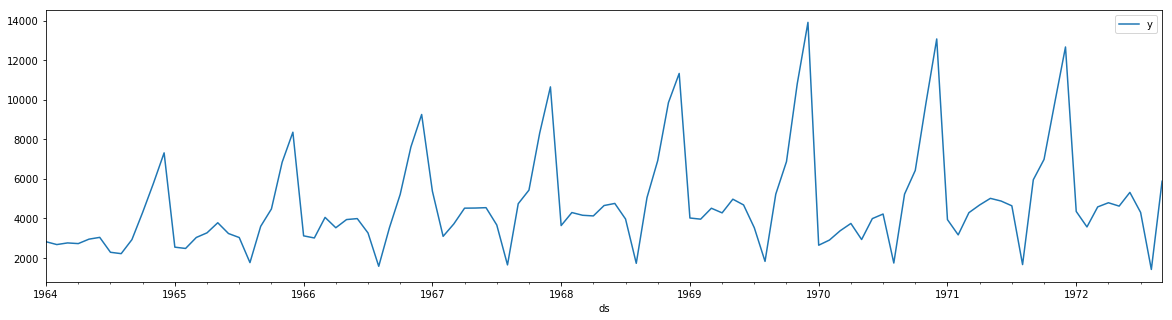

In [61]:
TSrev = build_indexed_ts(DSrev, 'ds', 'y')
TSvol = build_indexed_ts(DSvol, 'ds', 'y')
TSstock = build_indexed_ts(DSstock, 'date', 'volume')

#TSrev.plot(figsize=(20,5))
TSvol.plot(figsize=(20,5))
#TSstock.plot(figsize=(20,5))


In [234]:
#ts to supervised learning
def prepareWithoutLabel(serie, dim):
    sequence_length = dim
    size = len(serie)
    result = []
    for i in range(size-sequence_length):
        result.append(serie[i:i+sequence_length])
        
    result = np.array(result) 
    
    number_of_sequence = result.shape[0]
    train_set_size = round(0.8 * number_of_sequence)
    
    train_set = result[:int(train_set_size), :]
    
    x_train = train_set[:, :]
    x_test = result[int(train_set_size):, :]
    
    return [x_train, x_test]

In [6]:
# create a differenced series

def shiftter(dataset, shift=1):
    diff = list()
    for i in range(shift, len(dataset)):
        value = dataset[i] - dataset[i - shift]
        diff.append(value)
    return pd.Series(diff)

In [167]:
# Diff & Normalisation for series. Return train and test sets ready for supervised learning
def prepare_for_lstm(series, n_seq):
    # extract points
    points = series.values
    
    # transform data to be stationary
    diff_series = shiftter(points)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    
    # transform into supervised learning problem X, y
    X_train, X_test = prepareWithoutLabel(scaled_values,n_seq)
    return scaler, X_train, X_test

In [360]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    y = y.reshape(y.shape[0], y.shape[1])
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, dropout=0.4, kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    # fit network
    print("Fitting..........")
    tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
    evaluator = model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False, validation_split=0.1, 
                          callbacks=[tbCallBack])
    print("LSTM Fitted")
    return model, evaluator

In [302]:
# Used for cross validation grid search, function to create model, required for KerasClassifier
def create_model(n_batch, nb_epoch, n_neurons, optimizer='adam'):
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [10]:
def make_forecasts(model, n_batch, test, n_lag):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [11]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [12]:
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [13]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_seq):
    score = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        nrmse =  rmse/(np.max(actual)-np.min(actual))
        #print('t+%d RMSE: %f' % ((i+1), rmse))
        #print('t+%d NRMSE: %f' % ((i+1),nrmse))
        score.append(nrmse)
    print('NRMSE average : %f' % np.mean(score))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test,val=0):
    # plot the entire dataset in blue
    plt.figure(figsize=(20,5))
    plt.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
        
    # show the plot
    plt.show()

In [353]:
#Prepare points
window_size = 6
scaler, X_train, X_test = prepare_for_lstm(TSrev, window_size)

/Users/simo-mac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [364]:
# fit model
n_lag=5
n_batch=1
nb_epoch=100
n_neurons=10

global_start_time = time.time()  
model, evaluator = fit_lstm(X_train, n_lag, n_batch, nb_epoch, n_neurons)
print('Training duration (s) : ', time.time() - global_start_time)

Fitting..........
Train on 898 samples, validate on 100 samples
Epoch 1/100
898/898 [==============================] - 7s - loss: 0.0242 - acc: 0.2027 - val_loss: 0.0016 - val_acc: 0.2000

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


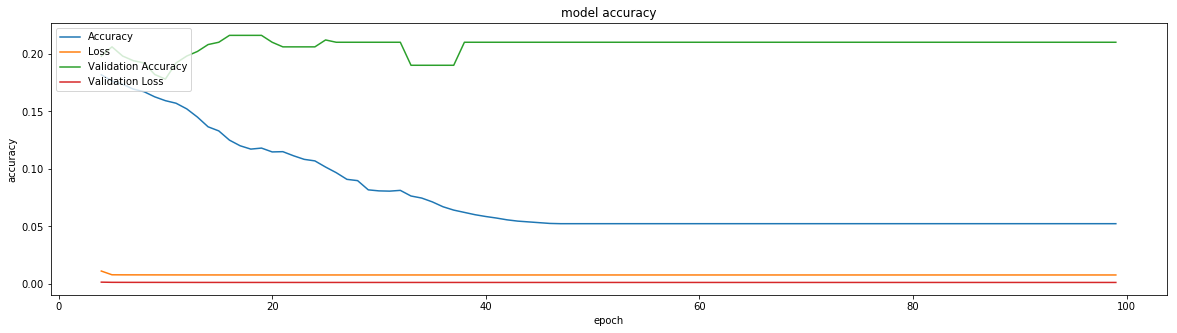

In [362]:
print(evaluator.history.keys())
# summarize history for accuracy
plt.figure(figsize=(20,5))

plt.plot(pd.Series(evaluator.history['acc']).rolling(window=5,center=False).mean())
plt.plot(pd.Series(evaluator.history['loss']).rolling(window=5,center=False).mean())
plt.plot(pd.Series(evaluator.history['val_acc']).rolling(window=5,center=False).mean())
plt.plot(pd.Series(evaluator.history['val_loss']).rolling(window=5,center=False).mean())
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss', 'Validation Accuracy', 'Validation Loss'], loc='upper left')
plt.show()

Forcast duration (s) :  7.1425840854644775
NRMSE average : 0.132649


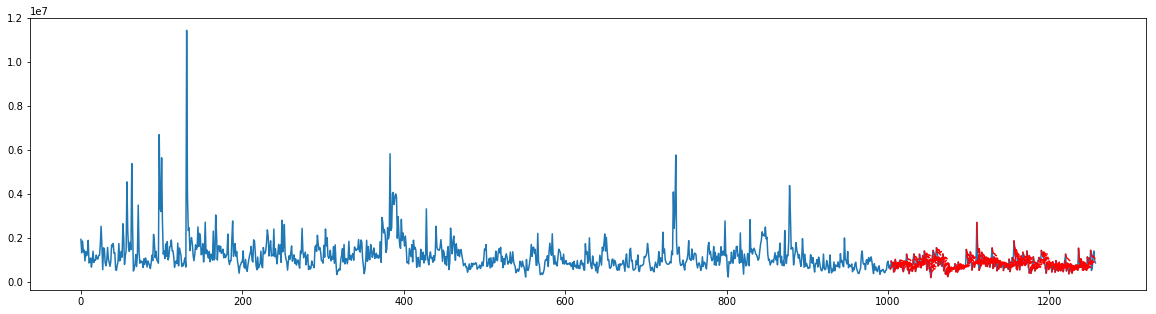

In [351]:
n_test = X_test.shape[0]

# make forecasts
global_start_time = time.time()  
forecasts = make_forecasts(model, n_batch, X_test, n_lag)
print('Forcast duration (s) : ', time.time() - global_start_time)
# inverse transform forecasts and test
forecasts = inverse_transform(TSrev.y, forecasts, scaler, n_test+window_size-n_lag)

actual = [row[n_lag:] for row in X_test]
actual = inverse_transform(TSrev.y, actual, scaler, n_test+window_size-n_lag)

# evaluate forecasts
evaluate_forecasts(actual, forecasts, window_size-n_lag)
# plot forecasts
plot_forecasts(TSrev.y, forecasts, n_test+window_size-n_lag)

In [293]:
#model viz
plot_model(model, to_file='TSrev.png',show_shapes=True)

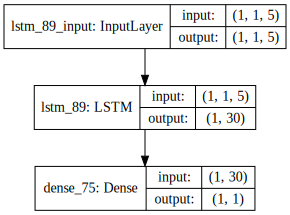

In [343]:
#local viz
SVG(model_to_dot(model,show_shapes=True,).create(prog='dot', format='svg'))

In [ ]:
#Hyperparameter optimisation section TODO

NameError: name 'Y' is not defined